In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import datetime as dt
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import multiprocessing
import numpy as np
import pandas as pd
from logistic_regression import *
import requests
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### options

In [2]:
cpu_count = multiprocessing.cpu_count()
print(f'cores to utilize:   {cpu_count} of {multiprocessing.cpu_count()}')

image_quality = 'HIGH' # can be set to LOW
print(f'number of features: {(256 if image_quality == "HIGH" else 64)}')

cores to utilize:   2 of 2
number of features: 256


### notes
* this notebook requires around 4.5gb of ram to run all cells
* you can set the number of processor cores to  use by altering the variable above
* image quality for training can be set with either LOW or HIGH. low will use scikit-learn's 64 bit digit set and HIGH will use ISLR's 256 bit.

### Load and scale data set

In [4]:
if image_quality == 'LOW':
    x, y = load_digits(return_X_y=True)
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
    shape = (8, 8)
    del x, y
else:
    train = pd.read_csv('zip.train', sep=' ')
    test  = pd.read_csv('zip.test', sep=' ')
    x_train, y_train = train.values[:, 1:-1], train.values[:, 0]
    x_test,  y_test  = test.values[:, 1:], test.values[:, 0]
    shape = (16, 16)
    del train, test

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Train a single class in OvR

In [5]:
def train_one(args):
    """trains a single one in one vs rest
    
    Args:
        args: (pos, queue)
        pos: (int) positive class number 
        queue: (Queue) log output queue
    """
    pos, queue = args
    
    # separate classes in the training set
    idx = np.where(y_train == pos)
    ya = y_train**0*-1
    ya[idx] = 1
    ya = np.array(ya).reshape(len(ya), )
    
    # fit
    clf = MyLogisticRegression()
    clf = clf.fit(x_train=x_train, y_train=ya, pos=pos, queue=queue)
    
    return clf

### Train OvR
The following code snippit optimizes each classifier in parallel while projecting the updating classifiers as they iterate through gradient descent. The procedure takes around 20 minutes on my machine to fully train all classes when using 256 features and, 2 minutes for 64 features.

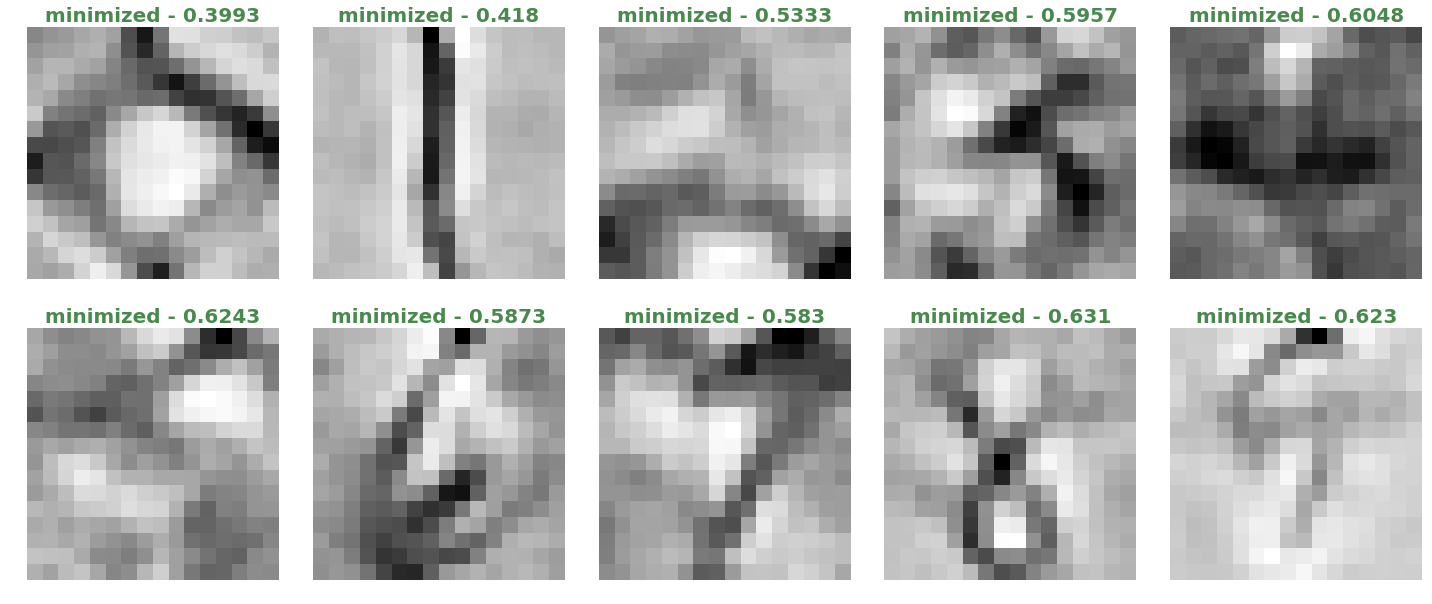

In [6]:
def redraw():
    """redraw the plot canvas"""
    fig.canvas.flush_events()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    fig.tight_layout()
    fig.canvas.draw()

# create the plot and add subplots
fig = plt.figure(figsize=(20, 20))
ax_list = [fig.add_subplot(2,5,i) for i in range(1, 11)]

fig.set_tight_layout(True)

# set starting image to match initial beta values
for i, ax in enumerate(ax_list):
    t = ax.imshow(np.zeros(shape), cmap='Greys')
    t = ax.set_aspect('equal')
    t = ax.set_title(f'{i}', fontsize=20, fontweight='bold')
    t = ax.axis('off')

# start a process pool to train each OvR
manager = multiprocessing.Manager()
log_queue = manager.Queue()

pool = multiprocessing.Pool(cpu_count)
res  = [pool.map_async(train_one, [(i, log_queue) for i in range(10)])]

# catch trainint output until all processes finish training
running, i, cache, max_iter = 10, 0, [[] for i in range(10)], 0
while running > 0:
    args = log_queue.get()
    i += 1
    
    # cache the log
    idx = args['klass']    
    cache[idx].append(args)
    obj = np.round(args['obj'], 4)
    
    # process classifier completion
    if args['iter'] == 'END':
        ax_list[idx].set_title(f'minimized - {np.round(obj, 4)}', 
                               fontsize=20, fontweight='bold', color='#478A4C')
        redraw()
        running -= 1
        
        # break or continue
        if running == 0:
            break
        else:
            continue
    
    # update max iteration
    max_iter = args['iter'] if args['iter'] > max_iter else max_iter
    
    # update the reporting subplot
    ax_list[idx].clear()
    ax_list[idx].imshow(args['coef'].reshape(shape), cmap='Greys')
    ax_list[idx].set_aspect('equal')
    ax_list[idx].axis('off')
    ax_list[idx].set_title(f'iter: {args["iter"]} - loss: {obj}',
                           fontsize=20, fontweight='bold')
    redraw()

pool.close()
pool.join()
plt.close();

### Comparing my Logistic Regression class to scikit-learn's
I first generate a simulated dataset then train, and finally plot the resulting validation error.

scikit error: 0.152
my error: 0.152


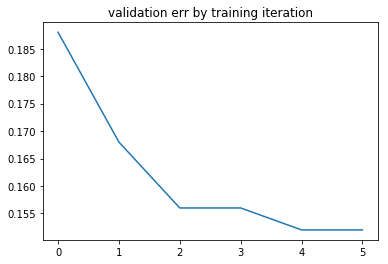

In [4]:
# generate the simulated data set
x, y = make_classification(1000, random_state=42)
y[y == 0] = -1

# split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# standardize the data
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# setup a queue for tracking progress
queue = multiprocessing.Queue()

# train my Logistic Regression
clf = MyLogisticRegression()
mykit = clf.fit(x_train=x_train, y_train=y_train, pos=1, neg=-1, queue=queue)

# train scikit's
scikit = LogisticRegression(solver='sag').fit(x_train, y_train)

# compare validation performance
err = []
while not queue.empty():
    el = queue.get()
    yhat = clf.predict(x_test, el['coef'])
    err.append(np.mean(yhat != y_test))

plt.plot(np.arange(len(err)), err)
t = plt.title('validation err by training iteration')

yhat = scikit.predict(x_test)
s_err = np.mean(yhat != y_test)

print(f'scikit error: {s_err}')
print(f'my error: {err[-1]}')